# **SVM applied to Detecting Insults in Social Commentary;. Available from: https://kaggle.com/c/detecting-insults-in-social-commentary.**

# Quelle: https://github.com/importdata/Twitter-Sentiment-Analysis

Import Libraries

In [1]:
import sklearn
import numpy as np
import pandas as pd

Import Data

In [2]:
# Je nach Dataset müssen wir dieses evtl aufteilen um Trainings- und Testdaten zu erhalten (70/30)

# training data
train = pd.read_csv("./datasets/detecting-insults-in-social-commentary/train.csv")

# test data without labels to see how our classifiers perform on unlabeled and unseen data
test = pd.read_csv("./datasets/detecting-insults-in-social-commentary/test.csv")

# test data with labels to calculate metrices
testWithSolutions = pd.read_csv("./datasets/detecting-insults-in-social-commentary/test_with_solutions.csv")

In [3]:
train.head()
train.tail()

,Insult,Date,Comment
3942,1,20120502172717Z,"""you are both morons and that is never happening"""
3943,0,20120528164814Z,"""Many toolbars include spell check, like Yahoo..."
3944,0,20120620142813Z,"""@LambeauOrWrigley\xa0\xa0@K.Moss\xa0\nSioux F..."
3945,0,20120528205648Z,"""How about Felix? He is sure turning into one ..."
3946,0,20120515200734Z,"""You're all upset, defending this hipster band..."


In [4]:
test.head()
test.tail()

,id,Date,Comment
2230,2231,20120528100303Z,"""FUCKIN LAME COME ON WTF STOP FUCKING OVER MY ..."
2231,2232,20120531185813Z,"""YOU SHUT YOUR IGNORANT PIE HOLE YOU LITTLE IN..."
2232,2233,20120529130822Z,"""sweetie pie is looking very much like her cou..."
2233,2234,20120531045826Z,"""ball4real where are you with your miami g-ayn..."
2234,2235,20120531184524Z,"""Man....if you are a 3 point shooter, you must..."


In [5]:
testWithSolutions.head()
testWithSolutions.tail()

,Insult,Date,Comment,Usage
2642,0,20120612003508Z,"""Never really gave it much thought. I just fig...",PrivateTest
2643,0,20120619210456Z,"""Nadie se salva de la regla 34 xd""",PrivateTest
2644,0,20120528234613Z,"""Question: Are you a boy or a girl?""",PrivateTest
2645,1,20120619153537Z,"""Leave your email or phone number and maybe yo...",PrivateTest
2646,0,20120620000237Z,"""From the scenarios you present, I see you bel...",PrivateTest


Einträge der verschiedenen Label zählen

In [6]:
# non-toxic comment
# Spalte der Label in Anführungszeichen angeben
sum(train["Insult"] == 0)

2898

In [7]:
# toxic comment
sum(train["Insult"] == 1)

1049

Überprüfung ob fehlende Einträge vorhanden sind

In [8]:
train.isnull().sum()
# train.isnull().values.any()

Insult       0
Date       718
Comment      0
dtype: int64

Müssen die Daten noch aufgeräumt werden?


*   Sind special characters vorhanden? -> remove
*   also remove Punctuation (wie geht man mit "z.B." oder "U.S.A" um?)
*   tweet-preprocessor?

In [9]:
# remove special characters -> regex schnell und einfach
import re

#set up punctuations we want to be replaced
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")
REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?)|(-)|(/)|(:).")

In [10]:
!pip install tweet-preprocessor

In [11]:
import preprocessor as p

# custum function to clean the dataset (combining tweet_preprocessor and reguar expression)
def clean_tweets(df):
  tempArr = []
  for line in df:
    # send to tweet_processor
    tmpL = p.clean(line)
    # remove puctuation
    tmpL = REPLACE_NO_SPACE.sub("", tmpL.lower()) # convert all tweets to lower cases
    tmpL = REPLACE_WITH_SPACE.sub(" ", tmpL)
    tempArr.append(tmpL)
  return tempArr

In [12]:
# clean training data
train_tweet = clean_tweets(train["Comment"])
train_tweet = pd.DataFrame(train_tweet)


In [13]:
# append cleaned tweets to the training data
train["clean_tweet"] = train_tweet

# compare the cleaned and uncleaned tweets
train.head(10)

,Insult,Date,Comment,clean_tweet
0,1,20120618192155Z,"""You fuck your dad.""",you fuck your dad
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ...",i really dont understand your point\xa0 it see...
2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ...",a\\xc2\\xa0majority of canadians can and has b...
3,0,NaN,"""listen if you dont wanna get married to a man...",listen if you dont wanna get married to a man ...
4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd...",c\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1eddn...
5,0,20120620171226Z,"""@SDL OK, but I would hope they'd sign him to ...",ok but i would hope theyd sign him to a one y...
6,0,20120503012628Z,"""Yeah and where are you now?""",yeah and where are you now
7,1,NaN,"""shut the fuck up. you and the rest of your fa...",shut the fuck up you and the rest of your fagg...
8,1,20120502173553Z,"""Either you are fake or extremely stupid...may...",either you are fake or extremely stupidmaybe both
9,1,20120620160512Z,"""That you are an idiot who understands neither...",that you are an idiot who understands neither ...


In [14]:
# clean the test data and append the cleaned tweets to the test data
test_tweet = clean_tweets(test["Comment"])
test_tweet = pd.DataFrame(test_tweet)
# append cleaned tweets to the training data
test["clean_tweet"] = test_tweet

# compare the cleaned and uncleaned tweets
test.tail()

print(test)

        id             Date  \
0        1  20120603163526Z   
1        2  20120531215447Z   
2        3  20120823164228Z   
3        4  20120826010752Z   
4        5  20120602223825Z   
...    ...              ...   
2230  2231  20120528100303Z   
2231  2232  20120531185813Z   
2232  2233  20120529130822Z   
2233  2234  20120531045826Z   
2234  2235  20120531184524Z   

                                                Comment  \
0                    "like this if you are a tribe fan"   
1                 "you're idiot......................."   
2     "I am a woman Babs, and the only "war on women...   
3     "WOW & YOU BENEFITTED SO MANY WINS THIS YEAR F...   
4     "haha green me red you now loser whos winning ...   
...                                                 ...   
2230  "FUCKIN LAME COME ON WTF STOP FUCKING OVER MY ...   
2231  "YOU SHUT YOUR IGNORANT PIE HOLE YOU LITTLE IN...   
2232  "sweetie pie is looking very much like her cou...   
2233  "ball4real where are you with y

In [15]:
# clean the testWithSolutions data and append the cleaned tweets to the test data
testWithSolutions_tweet = clean_tweets(testWithSolutions["Comment"])
testWithSolutions_tweet = pd.DataFrame(testWithSolutions_tweet)
# append cleaned tweets to the training data
testWithSolutions["clean_tweet"] = testWithSolutions_tweet

# compare the cleaned and uncleaned tweets
testWithSolutions.tail()

print(testWithSolutions)

      Insult             Date  \
0          0              NaN   
1          0  20120618222256Z   
2          1  20120618213617Z   
3          0              NaN   
4          0  20120620003825Z   
...      ...              ...   
2642       0  20120612003508Z   
2643       0  20120619210456Z   
2644       0  20120528234613Z   
2645       1  20120619153537Z   
2646       0  20120620000237Z   

                                                Comment        Usage  \
0     "THE DRUDGE REPORT\\n\\n\\n\\nYou won't see th...   PublicTest   
1     "@ian21\xa0"Roger Clemens is the fucking man, ...   PublicTest   
2     "Agree with Alan you are an extremest idiot.  ...   PublicTest   
3     "Really?\\n\\nI see Marc Lamont Hill on variou...  PrivateTest   
4     "Really suck isn't the word, when many of our ...  PrivateTest   
...                                                 ...          ...   
2642  "Never really gave it much thought. I just fig...  PrivateTest   
2643                 "Nadie

In [16]:
from sklearn.model_selection import train_test_split

# extract the labels from the train data

# statt "Insult" hier wieder die Spalte angeben

y_train = train.Insult.values
y_testWithSolutions = testWithSolutions.Insult.values
x_testWithSolutions = testWithSolutions.clean_tweet.values
x_train = train.clean_tweet.values

Vectorize tweets using CountVectorizer

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
documents = ["This is a test document.",
             "I like trains",
             "Bla Blaa Blaaa",
            "I also just recognize words with more than 1 letter!!"]

# initializing the countvectorizer
vectorizer = CountVectorizer()

# tokenize and make the document into a matrix
document_term_matrix = vectorizer.fit_transform(documents)

# check the result
pd.DataFrame(document_term_matrix.toarray(), columns = vectorizer.get_feature_names())

,also,bla,blaa,blaaa,document,is,just,letter,like,more,recognize,test,than,this,trains,with,words
0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,1,0,1,1,0,1,0,0,1,1


In [19]:
from sklearn.feature_extraction.text import CountVectorizer

# vectorize tweets for model building
vectorizer = CountVectorizer(binary=True, stop_words='english')

# learn a vocabulary dictionary of all tokens in the raw documents
vectorizer.fit(list(x_train) + list(x_testWithSolutions))

# transform documents to document-term matrix
x_train_vec = vectorizer.transform(x_train)
x_test_vec = vectorizer.transform(x_testWithSolutions)
#x_valid_vec = vectorizer.transform(x_valid)


Model building

Apply Support Vetor Classifier (SVC)


In [20]:
from sklearn import svm
# classify using support vector classifier
svm = svm.SVC(kernel = 'linear', probability=True)

# fit the SVC model based on the given training data
prob = svm.fit(x_train_vec, y_train).predict_proba(x_test_vec)

predictions = svm.predict(x_train_vec)
predictionsToTest = svm.predict(x_test_vec)

# perform classification and prediction on samples in x_test / DAMIT berechnet man die Metriken
#y_pred_svm = svm.predict(x_valid_vec)
# perform classification and prediction on samples in x_test / NICHT geeignet zum Berechnen von Metriken, 
# da hier keine Labels zum Überprüfen unserer predicteten Labels vorhanden sind
#y_final_pred_svm = svm.predict(x_test_vec)

Accuracy score for SVC

In [21]:
from sklearn.metrics import accuracy_score
print("Accuracy score for SVC is: ", accuracy_score(predictionsToTest, y_testWithSolutions) * 100, '%')

Accuracy score for SVC is:  80.80846241027578 %


In [22]:
from sklearn.metrics import classification_report
print(classification_report(predictionsToTest,y_testWithSolutions))

from sklearn.metrics import f1_score
f1_score(predictionsToTest,y_testWithSolutions, average='macro')

              precision    recall  f1-score   support

           0       0.90      0.85      0.87      2072
           1       0.55      0.66      0.60       575

    accuracy                           0.81      2647
   macro avg       0.72      0.75      0.74      2647
weighted avg       0.82      0.81      0.81      2647



0.7365946270378189

Jetzt DataFrame mit Übersicht über toxische und nicht toxische Kommentare erstellen

In [23]:
#print(y_pred_svm)
#print(y_test)

In [24]:
#representation = pd.DataFrame(x_test)
#print(representation)

# Das sind die Ergebnisse unseres Klassifikators

classifiedResults = {'Comment':x_valid, 'Prediction':y_pred_svm}
df = pd.DataFrame(classifiedResults,columns=['Comment','Prediction','Result'])
print(df)



NameError: name 'x_valid' is not defined

Ergebnis unseres Klassifikators

In [ ]:
# Ersetzen von Spaltenwerten mit Bedingungen in Pandas DataFrame
# https://www.delftstack.com/de/howto/python-pandas/pandas-replace-values-in-column/#ersetzen-von-spaltenwerten-mit-bedingungen-in-pandas-dataframe
df.loc[df.Prediction<1,'Result']='non-toxic'
df.loc[df.Prediction>0,'Result']='toxic'

print(df)

In [ ]:
# Das sind die von Experten gelabelten Ergebnisse zum Vergleich

labeledResults = {'Comment':x_valid, 'Prediction':y_valid}
dfCheck = pd.DataFrame(classifiedResults,columns=['Comment','Prediction','Result'])
# Ersetzen von Spaltenwerten mit Bedingungen in Pandas DataFrame
# https://www.delftstack.com/de/howto/python-pandas/pandas-replace-values-in-column/#ersetzen-von-spaltenwerten-mit-bedingungen-in-pandas-dataframe
dfCheck.loc[df.Prediction<1,'Result']='non-toxic'
dfCheck.loc[df.Prediction>0,'Result']='toxic'

print(dfCheck)



In [ ]:
#toxicComments = []
#for comment in df:
#  toxicComments.append(df.Comment)

#print(toxicComments)

# **Naïve Bayes**

Herangehensweise:

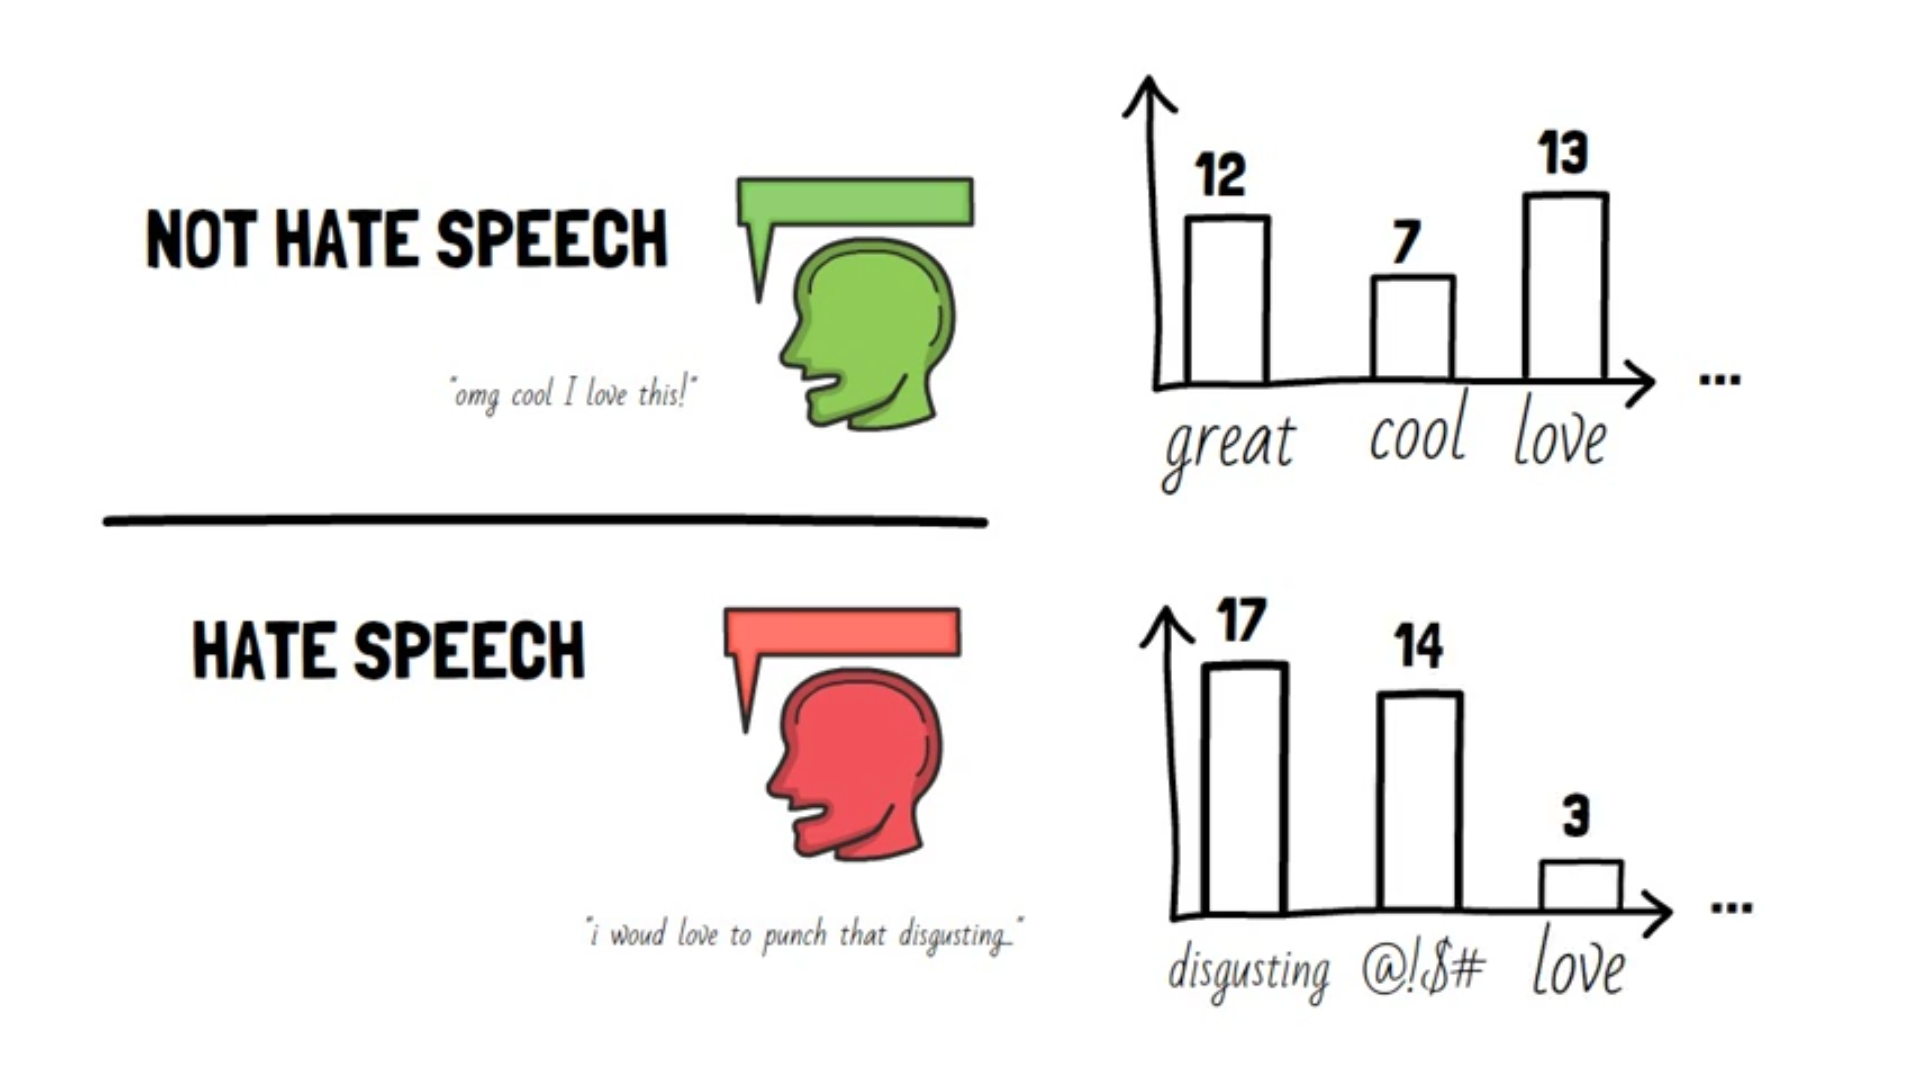

Quelle: https://www.youtube.com/watch?v=mOPHp0Rgvow

Import

In [31]:
import nltk
from sklearn.naive_bayes import GaussianNB

naiveBayes = GaussianNB()

y_train = train.Insult.values
x_train = train.clean_tweet.values

y_testWithSolutions = testWithSolutions.Insult.values
x_testWithSolutions = testWithSolutions.clean_tweet.values

from sklearn.feature_extraction.text import CountVectorizer

# vectorize tweets for model building
vectorizer = CountVectorizer(binary=True, stop_words='english')

# learn a vocabulary dictionary of all tokens in the raw documents
vectorizer.fit(list(x_train) + list(x_testWithSolutions))

# transform documents to document-term matrix
x_train_vec = vectorizer.transform(x_train)
x_test_vec = vectorizer.transform(x_testWithSolutions)

# Error : A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.
x_train_vec = x_train_vec.toarray()
x_test_vec = x_test_vec.toarray()


y_pred = naiveBayes.fit(x_train_vec, y_train).predict(x_test_vec)

print("Number of mislabeled points out of a total %d points : %d" % (x_test_vec.shape[0], (y_testWithSolutions != y_pred).sum()))

Number of mislabeled points out of a total 2647 points : 865


# **Logistic Regression** Quelle: https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a und https://www.youtube.com/watch?v=liOeXqqhmwc&list=PLU_Ql5itzbrYUG3t1Z6df8jbb4VpF4sjX

Step 1. Import the model you want to use

In [ ]:
from sklearn.linear_model import LogisticRegression

Step 2. Make an instance of the Model

In [ ]:
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

In [ ]:
from sklearn.model_selection import train_test_split

# extract the labels from the train data

# statt "Insult" hier wieder die Spalte angeben

y = train.Insult.values
x_test = test.clean_tweet.values

y_train = train.Insult.values
y_testWithSolutions = testWithSolutions.Insult.values
x_testWithSolutions = testWithSolutions.clean_tweet.values
x_train = train.clean_tweet.values



# use 70% for the training and 30% for Crossfold Validation (CV)
#x_train, x_valid, y_train, y_valid = train_test_split(train.clean_tweet.values, y, 
#                                                    stratify=y, 
#                                                    random_state=1, 
#                                                    test_size=0.3, shuffle=True)

Step 3.**Vectorize the comments using CountVectorizer like before, or tf-idf Vectorization** Converting the text into numbers so the computer could understand it

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# vectorize tweets for model building
vectorizer = CountVectorizer(binary=True, stop_words='english')

# learn a vocabulary dictionary of all tokens in the raw documents
vectorizer.fit(list(x_train) + list(x_testWithSolutions))

# transform documents to document-term matrix
x_train_vec = vectorizer.transform(x_train)
x_test_vec = vectorizer.transform(x_testWithSolutions)
#x_valid_vec = vectorizer.transform(x_valid)

Step 4. Training the model on the data, storing the information learned from the data

Model is learning the relationship between digits (x_train) and labels (y_train)

In [ ]:
# this line of code failes, because the computer can't understand the text!
# -> tf-idf Vectorization (convert text into numbers)
#print(x_test_vec)
logisticRegr.fit(x_train_vec, y_train)


predictions = logisticRegr.predict(x_train_vec)
predictionsToTest = logisticRegr.predict(x_test_vec)


Step 5. Predict labels for new data

In [ ]:
# Make predictions on entire test data
# DAMIT berechnet man die Metriken
#predictions = logisticRegr.predict(x_test_vec)

# NICHT geeignet zum Berechnen von Metriken, 
# da hier keine Labels zum Überprüfen unserer predicteten Labels vorhanden sind
#final_predictions = logisticRegr.predict(x_test_vec)
#print(predictions)

Measuring Model Performance

In [ ]:
# Use score method to get accuracy of model
#score = logisticRegr.score(predictionsToTest, y_testWithSolutions)
#print("Accuracy using Logistic Regression: "+str(score))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(predictionsToTest,y_testWithSolutions))

from sklearn.metrics import f1_score
f1_score(predictionsToTest,y_testWithSolutions, average='macro')

## Datensatz TestWithSolutions zur Berechnung der Metriken ausprobieren

In [ ]:
## import ##
testWithSolutions = pd.read_csv("./datasets/detecting-insults-in-social-commentary/test_with_solutions.csv")
testWithSolutions.head()

## Cleaning Data ##
# clean testWithSolutions data
testWithSolutions_tweet = clean_tweets(testWithSolutions["Comment"])
testWithSolutions_tweet = pd.DataFrame(testWithSolutions_tweet)
# append cleaned tweets to the training data
testWithSolutions["clean_tweet"] = testWithSolutions_tweet
# compare the cleaned and uncleaned tweets
testWithSolutions.head(10)
    
## Getting values ##
y = testWithSolutions.Insult.values
X = testWithSolutions.clean_tweet.values

## test and train split ##
x_train, x_test, y_train, y_test = train_test_split(testWithSolutions.clean_tweet.values, y, 
                                                    stratify=y, 
                                                    random_state=1, 
                                                    test_size=0.3, shuffle=True)

## Vectorizing ##
from sklearn.feature_extraction.text import CountVectorizer
# vectorize tweets for model building
vectorizer = CountVectorizer(binary=True, stop_words='english')
# learn a vocabulary dictionary of all tokens in the raw documents
vectorizer.fit(list(x_train) + list(X)+list(x_test))
# transform documents to document-term matrix
X_vec = vectorizer.transform(X)
x_train_vec = vectorizer.transform(x_train)
x_test_vec = vectorizer.transform(x_test)

## apply model (here: LogisticRegression) ##
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
    
# train model on data
logisticRegr.fit(x_train_vec, y_train)
#logisticRegr.fit(X_vec, y)
#logisticRegr.fit(X_vec, y_train)
    
# make prediction
#predictions = logisticRegr.predict(X_vec)
predictions = logisticRegr.predict(x_test_vec)
final_predictions = logisticRegr.predict(x_test_vec)
#print(predictions)

## Use score method to get accuracy of model ##
#score = logisticRegr.score(X_vec, y)
#print("Accuracy using Logistic Regression: "+str(score))
score = logisticRegr.score(x_test_vec, y_test)
print("Accuracy using Logistic Regression: "+str(score))

In [ ]:
#from sklearn.metrics import classification_report
#print(classification_report(x_test_vec,y_test))

#from sklearn.metrics import f1_score
#f1_score(x_test_vec,y_test, average='macro')

## Named Entity Extraction

In [ ]:
import pandas as pd
import spacy
from spacy.matcher import Matcher, PhraseMatcher
import seaborn as sns
from spacy.pipeline import EntityRuler
from spacy import displacy
from spacy.lang.de import German
from spacy.lang.en import English
import re
from spacy.pipeline import EntityRuler

In [ ]:
nlp = English()
ruler = EntityRuler(nlp)
#english_ruler = nlp.add_pipe(nlp.create_pipe('entity_ruler', config={"validate":True}))
english_ruler = nlp.add_pipe(ruler)

### 1. Anlegen einer Liste toxischer Begrifflichkeiten

In [ ]:
with open('./datasets/hatebase/lexicon.txt') as f:
    lexicon = f.read().lower().splitlines()
    
#print(lexicon[0])

### 2. Anlegen des Patterns

In [ ]:
toxic_pattern = [
    {"label": "TOXIC", "pattern": str(toxic_word)} for toxic_word in list(nlp.pipe(lexicon))
]
#print(toxic_pattern)

In [ ]:
pattern = toxic_pattern

In [ ]:
ruler.add_patterns(pattern)
#print(ruler.patterns)

In [ ]:
X = testWithSolutions.clean_tweet.values

comments_processed = nlp(np.array2string(X))
print(comments_processed.ents)

In [ ]:
print([(ent.text, ent.label_) for ent in comments_processed.ents])

In [ ]:
#colors = {"TOXIC": "blue"}
#options ={"ents": ["TOXIC"], "colors": colors}
print(comments_processed.ents)
print(comments_processed[2])

In [ ]:
displacy.render(comments_processed, style="ent")

In [ ]:
counter_toxic = 0
for ent in comments_processed.ents:
    if ent.label_ == "TOXIC":
        counter_toxic = counter_toxic + 1
print(counter_toxic)

In [ ]:
testWithSolutions.head()

# Using Transformers from Huggingface (https://huggingface.co/course/chapter2/2?fw=tf)

In [ ]:
!pip install transformers

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier([
    "I've been waiting for a HuggingFace course my whole life.", 
    "I hate this so much!",
])

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.", 
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="tf")
print(inputs)

In [ ]:
from transformers import TFAutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = TFAutoModel.from_pretrained(checkpoint)

In [ ]:
outputs = model(inputs)
print(outputs.last_hidden_state.shape)

In [ ]:
from transformers import TFAutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(inputs)

In [ ]:
print(outputs.logits.shape)

In [ ]:
print(outputs.logits)

In [ ]:
import tensorflow as tf

predictions = tf.math.softmax(outputs.logits, axis=-1)
print(predictions)

In [ ]:
model.config.id2label

Now we can conclude that the model predicted the following:

    First sentence: NEGATIVE: 0.0402, POSITIVE: 0.9598
    Second sentence: NEGATIVE: 0.9995, POSITIVE: 0.0005

In [ ]:
from transformers import BertConfig, TFBertModel

# Building the config
config = BertConfig()

# Building the model from the config
model = TFBertModel(config)

In [ ]:
print(config)

Different loading methods

In [ ]:
from transformers import BertConfig, TFBertModel

config = BertConfig()
model = TFBertModel(config)

# Model is randomly initialized!

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
  
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

**Preprocessing**


*   normalization
*   case folding

